# Setup

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from src.dataset import PosterDataset
from src.train import train, test
from src.models import Simple3BlockCNN, BNDropout3BlockCNN
from src.utils import split_data, print_history

In [2]:
BATCH_SIZE = 32
TRAIN_SIZE = 0.8
EPOCHS = 30
LEARNING_RATE = 1e-3
PATIENCE = 5

In [3]:
train_loader, val_loader, test_loader = split_data("data", batch_size=BATCH_SIZE, train_size=TRAIN_SIZE)

           Train    Val    Test
-------  -------  -----  ------
Samples     8000   1000    1000
Batches      250     32      32


# Training

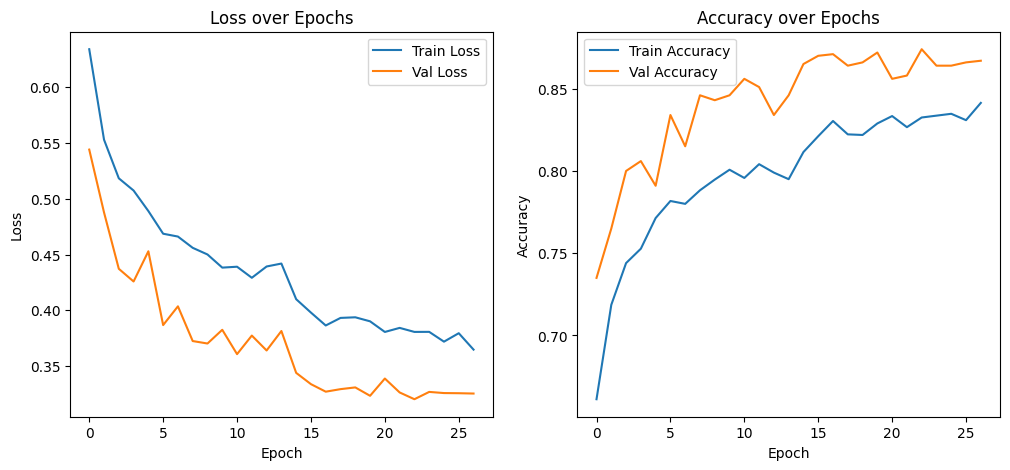

Epoch 27/30
  Train Loss: 0.3648, Train Acc: 0.8414
  Val   Loss: 0.3254, Val   Acc: 0.8670
  Best Val Acc: 0.8740 at Epoch 23
  Learning Rate: 0.000010


Early stopping at epoch 28
History saved to models/Simple3BlockCNN/run_3/history.json


In [4]:
model = Simple3BlockCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

history = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    patience=PATIENCE
)

In [5]:
history_path = "models/Simple3BlockCNN/run_3/history.json"
print_history(history_path)

Epoch      Train Loss    Val Loss    Train Acc    Val Acc
-------  ------------  ----------  -----------  ---------
1              0.6342      0.5442       0.6613      0.735
2              0.5531      0.4878       0.7186      0.765
3              0.5184      0.4373       0.744       0.8
4              0.5075      0.4259       0.7528      0.806
5              0.4891      0.453        0.7714      0.791
6              0.4687      0.3868       0.7817      0.834
7              0.4662      0.4036       0.78        0.815
8              0.4561      0.3725       0.7883      0.846
9              0.4501      0.3703       0.7947      0.843
10             0.4383      0.3826       0.8007      0.846
11             0.4391      0.3608       0.7957      0.856
12             0.4292      0.3774       0.8041      0.851
13             0.4393      0.364        0.799       0.834
14             0.442       0.3815       0.795       0.846
15             0.41        0.344        0.8115      0.865
16             0

# Testing

In [4]:
simple_model = Simple3BlockCNN()
simple_model_path = "models/Simple3BlockCNN/run_3/best_model.pth"
simple_model.load_state_dict(torch.load(simple_model_path))

enhanced_model = BNDropout3BlockCNN()
enhanced_model_path = "models/run_3/best_model.pth"
enhanced_model.load_state_dict(torch.load(enhanced_model_path))

criterion = nn.BCEWithLogitsLoss()

In [7]:
simple_test = test(model=simple_model,
                   test_loader=test_loader,
                   criterion=criterion)

enhanced_test = test(model=enhanced_model,
                     test_loader=test_loader,
                     criterion=criterion)

In [8]:
from tabulate import tabulate

table_data = [
    ["Simple3BlockCNN", round(simple_test[0], 3), simple_test[1]],
    ["BNDropout3BlockCNN", round(enhanced_test[0], 3), enhanced_test[1]],
]

headers = ["Model", "Loss", "Accuracy"]

print(tabulate(table_data, headers=headers))


Model                 Loss    Accuracy
------------------  ------  ----------
Simple3BlockCNN      0.333       0.865
BNDropout3BlockCNN   0.588       0.727
